In [1]:
from typing import Dict, Tuple
import pandas as pd
import csv
import json
import os
import sys
from pylab import *
from scipy import signal

sys.path.append("../")
import numpy as np
from serial_broker.Conversion import (
    voltage2force,
    VoltageToForceParameters,
    ParameterManager,
    AmplifierManager,
)
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
def get_section_info() -> Dict[str, str]:
    res = {}
    try:
        with open("../manifests/section.csv", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                block = str(row["block"])
                start_x = int(row["start_x"])
                start_y = int(row["start_y"])
                end_x = int(row["end_x"])
                end_y = int(row["end_y"])
                res[block] = (start_x, end_x, start_y, end_y)
        return res
    except Exception as e:
        print("error reading from csv file")
        raise e

def parse_file(path):
    res = []
    try:
        with open(path, "r") as f:
            while True:
                jline = f.readline()
                if not jline:
                    break
                res.append(json.loads(jline))
        return res
    except Exception as e:
        print("error reading from jsonl file")
        raise e


def custom_mapping_fn(x: np.ndarray):
    x[6][37] = x[6][38]
    return np.array(x)


In [3]:
section_info = get_section_info()
SURFACE = 1.9625e-5
ARRAY_SIZE = (24, 48)
# Init Calibration
M = ParameterManager()
M.read_from_csv("../manifests/calibration.csv")
C = M.params

# Init Amplifier
amp = AmplifierManager()
amp.read_from_csv("../manifests/amplifier.csv")
K = amp.get()

In [4]:
def split_raw_data(raw_data, section_info: Dict[str, Tuple[int, int, int, int]]):
    splited = {
        k: np.empty(shape=(len(raw_data), v[1] - v[0], v[3] - v[2]))
        for k, v in section_info.items()
    }
    timestamp = np.empty(len(raw_data))
    index = np.empty(len(raw_data), dtype=np.int64)
    total = np.empty(shape=(len(raw_data), *ARRAY_SIZE))
    for idx, dp in enumerate(raw_data):
        timestamp[idx] = dp["ts"]
        index[idx] = dp["index"]

        dp_data = np.array(dp["data"])
        dp_data = custom_mapping_fn(dp_data) * K
        dp_force = voltage2force(dp_data, params=C)
        #dp_pressure = 0.001*dp_force / SURFACE #单位：kPa
        dp_pressure = 0.001*dp_force / (SURFACE*150) #单位：kPa  #把150kPa视为最大值做归一化！！！

        for k in section_info.keys():
            start_x, end_x, start_y, end_y = section_info[k]
            try:
                splited[k][idx] = dp_pressure[start_x:end_x, start_y:end_y]
            except Exception as e:
                print(k)
                raise e
        total[idx] = dp_pressure
    return total, splited, timestamp, index

In [5]:
raw_data = parse_file("../log/20230718/20230718180832.jsonl")  #20230718的包饺子可用
total_pressure, splited_pressure, timestamp, index = split_raw_data(
    raw_data, section_info
)

f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: divide by zero encountered in divide
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in log
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)
f:\OneDrive\Tactile glove test\rfhand-serial-broker\playground\..\serial_broker\Conversion.py:23: RuntimeWarning: invalid value encountered in power
  res = 1 / params.k * np.power(-np.log((params.A - voltage) / (params.A - params.b)), 1 / params.d)


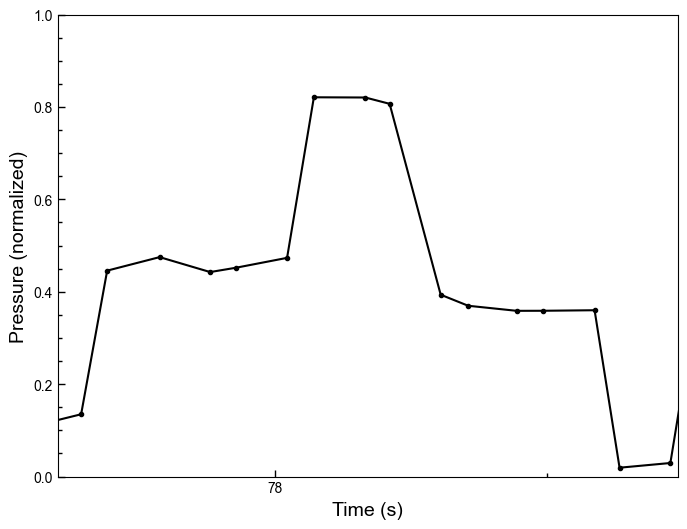

In [6]:
#作图：包饺子-捏
##########计算整个手掌平均压力：total_pressure.mean#########
plt.figure(figsize=(8, 6))
plt.rcParams["figure.dpi"] = 300  
axes = plt.subplot()
plt.xlabel('Time (s)', fontfamily='Arial', fontsize=14) 
plt.ylabel('Pressure (normalized)', fontfamily='Arial', fontsize=14) 
ax=plt.gca() #ax为两条坐标轴的实例
#刻度值字体设置
labels = ax.get_xticklabels()+ ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]


plt.xlim(77.6,78.74) #横轴，时间：秒  
plt.ylim(0,1) #纵轴，整个手掌的平均压强：kPa，归一化后的

axes.minorticks_on()  # 显示副刻度线
axes.tick_params(axis="both", which="major", direction="in", width=1, length=5) # 设置主刻度线参数
axes.tick_params(axis="both", which="minor", direction="in", width=1, length=3) # 设置副刻度线参数

ax=plt.gca()
#设置x,y 的主刻度定位器
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
# 设置 X 轴上的副刻度线之间的间隔
axes.xaxis.set_minor_locator(MultipleLocator(0.5)) 

plt.plot((timestamp - timestamp[0]) * 1e-9, total_pressure.mean(axis=(1, 2)), marker="o", color="black", linestyle='-', markersize=3)
plt.show()

In [8]:
data = {
    'X': (timestamp - timestamp[0]) * 1e-9,
    'Y': total_pressure.mean(axis=(1, 2))
}
df = pd.DataFrame(data)
df.to_csv('data_points（作图-20230718包饺子全程）.csv', index=False)